Configurations

In [1]:
import os
from omegaconf import OmegaConf
cfg = OmegaConf.load("../cfg.yaml")
print(cfg.path_rplan)
print(f"Path to RPLAN data exists: {os.path.exists(cfg.path_rplan)}")

/home/casper/Documents/Data/rplan/dataset/floorplan_dataset
Path to RPLAN data exists: True


Loads plan IDs

In [2]:
import re
# Extracts floor plan ids (ids)
ids = [int(re.search(r"\d+", p).group()) for p in os.listdir(cfg.path_rplan)]
ids.sort()
print(len(ids))
print(ids[:10])

80788
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Functions for extracting geometries and graph

In [3]:
import numpy as np
from rasterio import features
from shapely import geometry
from shapely.geometry import Polygon, MultiPolygon, box

from LayoutGKN.constants import CAT_RPLAN_ORIG, CAT_MAP

POLY_IMAGE = Polygon(((0, 0), (0, 256), (256, 256), (256, 0), (0, 0)))

def check_validity_polygon(poly):
    """Check the validity of a room polygon.
    The polygon shouldn't contain the whole image mask."""
    if poly == POLY_IMAGE: return False
    poly_mapped = geometry.mapping(poly)
    if len(poly_mapped) != 1:
        for subpoly in poly_mapped["coordinates"]:
            subpoly = Polygon(subpoly)
            if subpoly == POLY_IMAGE: return False
            else: return True


def extract_shapes_from_mask(mask, min_area=10):
    """Extracts all possible shapes from a binary mask."""
    shapes = features.shapes(mask, connectivity=4)
    polygons = []
    for s, _ in shapes:
        poly = Polygon(geometry.shape(s))
        if min_area < poly.area and check_validity_polygon(poly):
            polygons.append(poly)
    return polygons


def extract_rooms_from_image(img,
                             cat_rplan_orig=CAT_RPLAN_ORIG,
                             cat_map=CAT_MAP,  # category mapping from original RPLAN to new
                             min_area=10):
    """Extract room shapes from RPLAN images."""
    polygons = []
    categories = []
    classes = list(cat_rplan_orig.keys())
    for y in classes:
        if y > 12: continue  # > 12 are not room types
        mask = (img == y).astype(np.uint8)
        polygons_y = extract_shapes_from_mask(mask, min_area=min_area)
        polygons.extend(polygons_y)
        categories.extend([cat_map[y]]*len(polygons_y))  # convert category to new category
    return polygons, categories


def split_rectilinear(poly):
    """Split an axis-aligned rectilinear polygon (e.g., L-shape) into rectangles."""
    def _split_one(P):
        xs = sorted({round(x, 8) for x, _ in P.exterior.coords})
        ys = sorted({round(y, 8) for _, y in P.exterior.coords})
        rects = []
        for x0, x1 in zip(xs, xs[1:]):
            for y0, y1 in zip(ys, ys[1:]):
                cell = box(x0, y0, x1, y1)
                if P.contains(cell):            # keep full cells entirely inside
                    rects.append(cell)
        return rects or [P]
    if isinstance(poly, MultiPolygon):
        out = []
        for p in poly.geoms:
            out.extend(_split_one(p))
        return out
    return _split_one(poly)


def n_largest_polygons(polygons, n=2):
    """Finds the n largest polygons given a list of polygons."""
    return sorted(polygons, key=lambda p: p.area, reverse=True)[:n]


def extract_doors_from_image(img):
    """Extract door shapes from RPLAN images."""
    mask = (img == 17).astype(np.uint8)
    polygons = extract_shapes_from_mask(mask)
    splits = []
    for poly in polygons:
        # splits L-joint geometries (1st) into TWO (2nd line) doors
        polys = split_rectilinear(poly)
        if len(polys) > 1: polys = n_largest_polygons(polys, n=2)
        splits.extend(polys)
    return splits

Map shapes between (-1, 1) covering 20m in reality.

Each image is 18m x 18m. So: 256 pixels = 18m. So: 1 pixel = 18/256m. Hence: scaling factor = 1/256 * 18/10. 1/256 to map from pixel space to "unitless" space, 18/10 to map to "meter" space, and 1/2 because you want to map each floor plan between -1 and 1 (which spans 2 units). First, we do a translation or shift of 128 pixels to center the plan.

In [4]:
def transform_polygon(poly, shift=128, scale=1/256 * 18/10):
    """Transforms polygon based on a shift and scale."""
    poly_temp = np.array(poly.exterior.coords) - np.array(shift)
    poly_temp *= scale
    return Polygon(poly_temp)

Extract access graphs

In [5]:
from itertools import combinations
from shapely import affinity
from shapely.geometry import LineString
import networkx as nx
from LayoutGKN.utils import polygon_to_list

def rotate_polygon_90k(poly, k=1):
    """Rotate a Polygon by 90°*k around its center (centroid)."""
    return affinity.rotate(poly, 90*(k % 4), origin='centroid')


def midline_longest_side(poly):
    """Line through the polygon center."""
    rect = poly.minimum_rotated_rectangle
    xs = list(rect.exterior.coords)[:4]
    e = max([(xs[i], xs[(i+1)%4]) for i in range(4)],
        key=lambda ab: np.hypot(ab[1][0]-ab[0][0], ab[1][1]-ab[0][1]))
    L = np.hypot(e[1][0]-e[0][0], e[1][1]-e[0][1]) or 1e-12
    ux, uy = (e[1][0]-e[0][0])/L, (e[1][1]-e[0][1])/L
    c = rect.centroid
    return LineString([(c.x-0.5*L*ux, c.y-0.5*L*uy), (c.x+0.5*L*ux, c.y+0.5*L*uy)])


def create_orthogonal_lines(p: Polygon, N: int):
    """Generates a set of N lines orthogonal to A,
    centered on line A, uniformly spaced along A, and all with length L.
    They do not start at the end-points but at length(A)/(2N) from the end-points."""

    l = midline_longest_side(p)
    L = l.length
    margin = L / N / 2
    distances = np.linspace(margin, L - margin, N)
    delta = 1e-6
    orthogonal_lines = []

    for d in distances:
        p1 = l.interpolate(max(0, d - delta))
        p2 = l.interpolate(min(L, d + delta))
        dx = p2.x - p1.x
        dy = p2.y - p1.y
        # Orthogonal vector
        ox, oy = -dy, dx
        norm = np.hypot(ox, oy)
        ox, oy = ox / norm, oy / norm
        center = l.interpolate(d)
        offset = L / 2
        p_start = (center.x - ox * offset, center.y - oy * offset)
        p_end = (center.x + ox * offset, center.y + oy * offset)
        orthogonal_lines.append(LineString([p_start, p_end]))
    return orthogonal_lines


def get_geometry_feats(polygon):
    """Get geometrical features from polygon.
    Returns them in a list."""
    box = np.array(polygon.bounds)
    w = box[2] - box[0]  # width
    h = box[3] - box[1]  # height
    a =  np.sqrt(polygon.area)  # area
    cx, cy = polygon.centroid.xy  # center
    p = polygon.length / 4  # perimeter
    return np.array([cx[0], cy[0], w, h, a, p])


def check_access(p1, p2, polygons_door):
    """Checks if two room polygons are connected by a door."""
    for p_door in polygons_door:
        # creates N orthogonal lines w.r.t. door geometry
        lines = create_orthogonal_lines(p_door, N=3)
        if any([l.intersects(p1) and l.intersects(p2) for l in lines]): return True
    return False


def check_adjacency(p1, p2, b=0.05, aspect=2.0):
    """Checks if two room polygons are adjacent.
    It basically check whether the buffered overlap looks like a boundary segment:
    a strip, not a point / square-like geometry. Implemented as that the bounding box of the
    overlapping segment after dilating both room geometries should have
    a minimal aspect ratio between longest and shortest side."""
    segment = p1.buffer(b).intersection(p2.buffer(b))
    segment = split_rectilinear(segment)
    if len(segment) > 2: segment = n_largest_polygons(segment, n=1)[0]
    else: segment = segment[0]
    if segment.is_empty: return False
    segment_mrr = segment.minimum_rotated_rectangle
    xs = list(segment_mrr.exterior.coords)
    sides = [LineString([xs[i], xs[i+1]]).length for i in range(4)]
    return max(sides)/min(sides) >= aspect


def extract_access_graph(pid, polygons, categories, polygons_door):
    """Extracts the access graph from a set of room geometries
    and door geometries, including the room categories."""
    nodes = {}
    for n, (p, cat) in enumerate(zip(polygons, categories)):
        nodes[n] = {
            'polygon': polygon_to_list(p),
            'category': cat,
            'geometry': get_geometry_feats(p)
        }
    edges = []
    for i, j in combinations(nodes.keys(), 2):
        p1 = Polygon(nodes[i]['polygon'])
        p2 = Polygon(nodes[j]['polygon'])
        if check_access(p1, p2, polygons_door): edges.append([i, j, {"connectivity": 1}])
        elif check_adjacency(p1, p2): edges.append([i, j, {"connectivity": 0}])
        else: continue
    G = nx.Graph()
    G.graph["pid"] = pid  # plan ID as graph-level attribute
    G.add_nodes_from([(u, v) for u, v in nodes.items()])
    G.add_edges_from(edges)
    return G

Plotting stuff

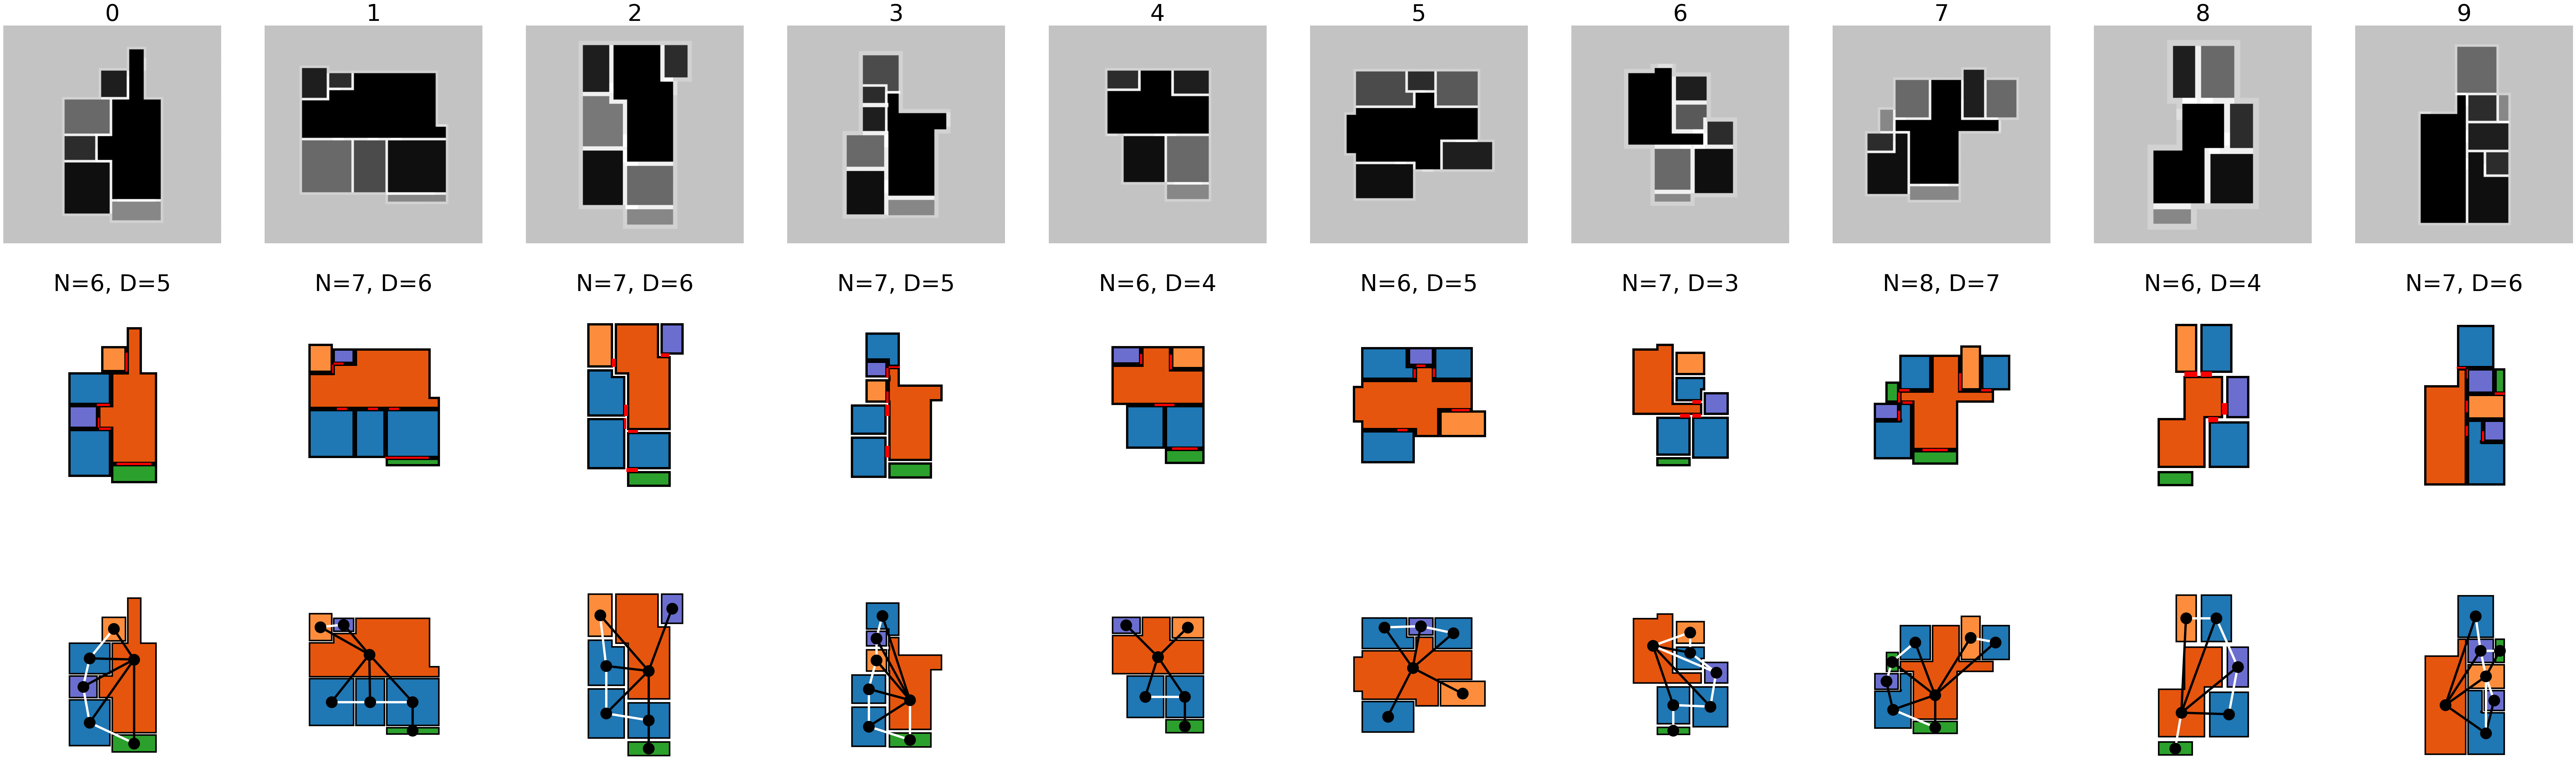

In [6]:
import matplotlib.pyplot as plt
from LayoutGKN.utils import load_image_rplan, minmax_normalize
from LayoutGKN.plot import draw_rooms, draw_polygon, draw_graph
from LayoutGKN.constants import ROOM_COLORS

n, fs = 10, 10
fig, axs = plt.subplots(3,n,figsize=(n*fs,3*fs)); axs = axs.flatten()
for ax in axs: ax.set_aspect('equal'); ax.axis('off')

for i in range(n):
    pid = ids[i]
    img = load_image_rplan(pid, cfg.path_rplan)
    # plots normalized image s.t. semantic differences become visible
    axs[i].imshow(minmax_normalize(img), cmap="gray")
    axs[i].set_title(pid, fontsize=fs*5)
    # flip image s.t. y-axis is read from bottom to top
    img = np.flipud(img)
    # extract
    polygons, categories = extract_rooms_from_image(img)
    polygons_door = extract_doors_from_image(img)
    polygons = [transform_polygon(p) for p in polygons]
    polygons_door = [transform_polygon(p) for p in polygons_door]
    G = extract_access_graph(pid, polygons, categories, polygons_door)
    # draw
    axs[i+n].set_xlim([-1, 1]); axs[i+n].set_ylim([-1, 1])
    colors = [ROOM_COLORS[cat] for cat in categories]
    draw_rooms(axs[i+n], polygons, colors, lw=5)
    _ = [draw_polygon(axs[i+n], p, facecolor="red") for p in polygons_door]
    axs[i+n].set_title(f"N={len(polygons)}, D={len(polygons_door)}", fontsize=fs*5)
    draw_graph(axs[i+2*n], G, fs=fs, s=fs*6, w=fs/2, lw=fs/3)
    axs[i+2*n].set_xlim([-1, 1]); axs[i+n].set_ylim([-1, 1])

In [8]:
import random
from tqdm import tqdm
from LayoutGKN.utils import save_pickle
graphs = []
ids_sample = random.sample(ids, k=1000)
for pid in tqdm(ids_sample):
    # load image and flip vertically
    img = load_image_rplan(pid, cfg.path_rplan)
    img = np.flipud(img)
    # extract
    polygons, categories = extract_rooms_from_image(img)
    polygons_door = extract_doors_from_image(img)
    polygons = [transform_polygon(p) for p in polygons]
    polygons_door = [transform_polygon(p) for p in polygons_door]
    G = extract_access_graph(pid, polygons, categories, polygons_door)
    graphs.append(G)
save_pickle(graphs, os.path.join(cfg.path_data, "rplan", "nx_graphs.pkl"))

100%|██████████| 1000/1000 [01:45<00:00,  9.48it/s]
